In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load dataset
df = pd.read_csv(r"C:\Users\harsh\Downloads\glycosylation_project\FEATURE_data_three_rows.csv")

# Extract target variable (Y)
Y = df['label']

# Identify categorical amino acid columns for q3 and q8
amino_acid_cols = ["q3_A1", "q3_A2", "q3_A3", "q8_A1", "q8_A2", "q8_A3"]

# Apply One-Hot Encoding (OHE) for q3 and q8 columns
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_amino_acids = encoder.fit_transform(df[amino_acid_cols])

# Convert to DataFrame with proper column names
encoded_cols = encoder.get_feature_names_out(amino_acid_cols)
encoded_amino_acids_df = pd.DataFrame(encoded_amino_acids, columns=encoded_cols, index=df.index)

# Drop original q3 and q8 columns from df
df.drop(columns=amino_acid_cols, inplace=True)

# Merge the encoded features back into the dataset
df = pd.concat([df, encoded_amino_acids_df], axis=1)

# Additional numerical features (asa, rsa, phi, psi, disorder for A1, A2, A3)
additional_numerical_cols = [
    "asa_A1", "asa_A2", "asa_A3",
    "rsa_A1", "rsa_A2", "rsa_A3",
    "phi_A1", "phi_A2", "phi_A3",
    "psi_A1", "psi_A2", "psi_A3",
    "disorder_A1", "disorder_A2", "disorder_A3"
]

# Extract numerical features
X_additional_numerical = df[additional_numerical_cols].values

# Find the starting column index for 'Feature_1_A1'
feature_start_col = df.columns.get_loc("Feature_1_A1")

# Find the ending column index for 'Feature_2560_A3' dynamically
feature_end_col = df.columns.get_loc("Feature_2560_A3") + 1  # +1 to include the 'Feature_2560_A3' column

# Extract the numerical features from 'Feature_1_A1' to 'Feature_2560_A3'
X_numerical_features = df.iloc[:, feature_start_col:feature_end_col].values  # Extract all numerical features

# Combine encoded categorical features with numerical features (asa, rsa, phi, psi, disorder, and Feature columns)
X_independent = np.hstack((X_additional_numerical, X_numerical_features))

# Split dataset into training (80%) and testing (20%)
X_train_final, X_test_final, Y_train_final, Y_test_final = train_test_split(
    X_independent, Y, test_size=0.2, random_state=SEED, stratify=Y
)

# Define MLP model architecture
mlp_model_final = keras.Sequential([
    layers.Input(shape=(X_train_final.shape[1],)),  # Input layer dynamically set to feature size

    # Hidden layers with ReLU activation, L2 regularization, and Dropout
    layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.05)),
    layers.Dropout(0.3),

    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),

    layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.005)),
    layers.Dropout(0.2),

    # Output layer with sigmoid activation
    layers.Dense(1, activation="sigmoid")
])

# Compile model
mlp_model_final.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Set up EarlyStopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train model
history_final = mlp_model_final.fit(
    X_train_final, Y_train_final, epochs=400, batch_size=128,
    validation_data=(X_test_final, Y_test_final), callbacks=[early_stopping], verbose=1
)

# Retrieve final training and testing accuracy
final_train_accuracy = history_final.history['accuracy'][-1]  
final_test_accuracy = history_final.history['val_accuracy'][-1]

# Get predictions on test set
Y_pred_final = mlp_model_final.predict(X_test_final)
Y_pred_final = (Y_pred_final > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate evaluation metrics
accuracy = accuracy_score(Y_test_final, Y_pred_final)
precision = precision_score(Y_test_final, Y_pred_final)
recall = recall_score(Y_test_final, Y_pred_final)
f1 = f1_score(Y_test_final, Y_pred_final)
roc_auc = roc_auc_score(Y_test_final, Y_pred_final)

# Confusion matrix
conf_matrix = confusion_matrix(Y_test_final, Y_pred_final)
TN, FP, FN, TP = conf_matrix.ravel()

# Print results
print(f"Final Training Accuracy: {final_train_accuracy}")
print(f"Final Testing Accuracy: {final_test_accuracy}")

# Print classification report
print("\nFinal Classification Report:")
print(classification_report(Y_test_final, Y_pred_final))

# Print additional metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"ROC AUC: {roc_auc}")

# Print confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")
print(f"True Positives: {TP}")
print(f"True Negatives: {TN}")


Epoch 1/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.5882 - loss: 19.7911 - val_accuracy: 0.6998 - val_loss: 4.3459
Epoch 2/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6556 - loss: 3.5270 - val_accuracy: 0.6980 - val_loss: 2.4676
Epoch 3/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6812 - loss: 2.4204 - val_accuracy: 0.7123 - val_loss: 2.0932
Epoch 4/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6927 - loss: 2.0327 - val_accuracy: 0.7211 - val_loss: 1.8451
Epoch 5/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6967 - loss: 1.8266 - val_accuracy: 0.7211 - val_loss: 1.6929
Epoch 6/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.7110 - loss: 1.6744 - val_accuracy: 0.7229 - val_loss: 1.5601
Epoch 7/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.7168 - loss: 1.5385 - val_accuracy: 0.7140 - val_loss: 1.4429
Epoch 8/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.7365 - loss: 1.4197 - val_accuracy: 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


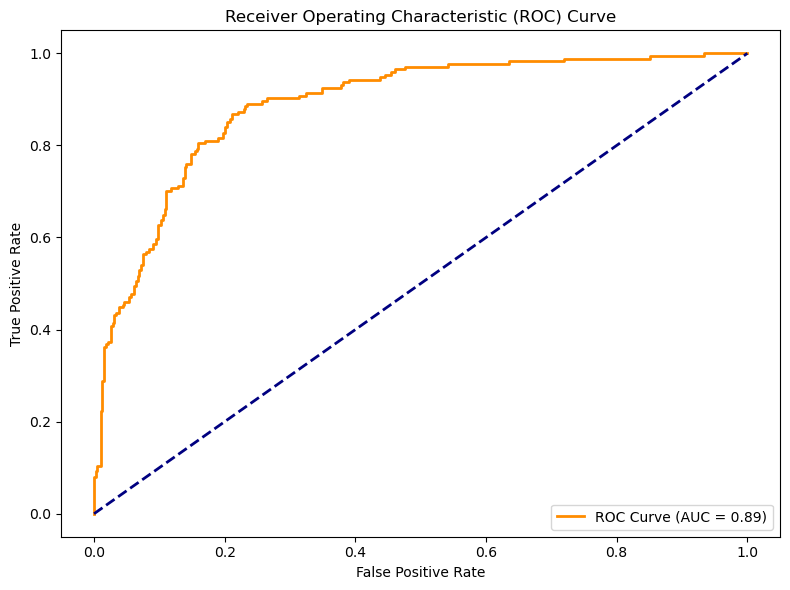

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for ROC AUC curve
Y_proba_final = mlp_model_final.predict(X_test_final)

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(Y_test_final, Y_proba_final)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


In [4]:
# Save entire model to HDF5 file
mlp_model_final.save("mlp_final_model.h5")
print("Model saved as 'mlp_final_model.h5'")


Model saved as 'mlp_final_model.h5'


In [2]:
import pandas as pd
df = pd.read_csv(r"C:\Users\harsh\Downloads\glycosylation_project\FEATURE_data_three_rows.csv")
df

,label,PID,sequence_window,Position,A1,A2,A3,Feature_1_A1,Feature_2_A1,Feature_3_A1,...,phi_A2,psi_A2,disorder_A2,rsa_A3,asa_A3,q3_A3,q8_A3,phi_A3,psi_A3,disorder_A3
0,0,A0A182BSS3,LSESATSSSSSSALDHKSSAPGEATNASETEHSAASTASEPKHEGP...,74,N,A,S,0.045070,-0.023967,0.158874,...,-76.571976,-4.282070,0.981877,0.678514,105.169671,C,C,-80.760605,13.322247,0.984383
1,0,P14844,VFYKIASTLRTSAPLNVNLTHKSEANASTLFSTTTSSTSVEVTSMTEN,126,N,A,S,0.178312,-0.032688,0.020413,...,-75.911453,-11.878099,0.973971,0.619576,96.034240,C,C,-81.566826,-10.591916,0.979155
2,0,Q6YXX9,AACQGVITSTEGKSDPLLPVTIGPENASWERWFQRVRSSRSNKWWA...,123,N,A,S,-0.042997,-0.080012,0.015932,...,-71.471199,-27.034119,0.299911,0.484007,75.021025,C,C,-73.088280,-24.561695,0.280864
3,0,B0FHH8,AVCSVKEVRINPCNPNKKCIFKKGVNASISFDFEPNFASSKLVTTL...,58,N,A,S,0.163269,-0.057696,-0.249951,...,-128.699615,149.261871,0.000767,0.180065,27.910113,E,E,-137.521622,148.153213,0.000742
4,0,B3GS44,LFANECRERKDGLVCPLPPLYSHNLNASTADSTPRFISLLISAATA...,137,N,A,S,-0.014989,0.096640,0.042269,...,-72.687668,-9.597672,0.992666,0.504823,78.247496,C,C,-73.662025,-4.068366,0.996532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2808,1,Q15113,AATASLLGPLLTACALLPFAQGQTPNYTRPVFLCGGDVKGESGYVA...,29,N,Y,T,0.107345,-0.203020,0.045506,...,-90.831680,59.890812,0.350508,0.687896,118.318166,C,C,-102.705933,118.860039,0.213712
2809,1,Q15389,LQRDAPHVEPDFSSQKLQHLEHVMENYTQWLQKLENYIVENMKSEM...,92,N,Y,T,0.031277,-0.054776,0.097169,...,-64.252640,-41.476685,0.037082,0.519199,89.302312,H,H,-65.148918,-40.775684,0.038184
2810,1,Q6BAA4,WYDKVVYKLHYYHDGQAVRYFHSSANYTVLQARASDSGRYQCSGTM...,152,N,Y,T,0.061311,-0.080898,-0.287368,...,-134.929871,138.131287,0.000626,0.372342,64.042848,E,E,-111.992287,132.278793,0.000624
2811,1,Q6UWY0,SRAAMWSGLFTHLTESWNNFKGLDPNYTTWMDVMERHGYRTQKFGK...,108,N,Y,T,0.158582,0.024604,-0.046815,...,-107.464386,126.424995,0.001151,0.177100,30.461180,C,C,-89.644913,127.764526,0.000509


# saving model in .h5 format

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import joblib

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load dataset
df = pd.read_csv(r"C:\Users\harsh\Downloads\glycosylation_project\FEATURE_data_three_rows.csv")

# Extract target variable (Y)
Y = df['label']

# Identify categorical amino acid columns for q3 and q8
amino_acid_cols = ["q3_A1", "q3_A2", "q3_A3", "q8_A1", "q8_A2", "q8_A3"]

# Apply One-Hot Encoding (OHE) for q3 and q8 columns
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_amino_acids = encoder.fit_transform(df[amino_acid_cols])

# Convert to DataFrame with proper column names
encoded_cols = encoder.get_feature_names_out(amino_acid_cols)
encoded_amino_acids_df = pd.DataFrame(encoded_amino_acids, columns=encoded_cols, index=df.index)

# Drop original q3 and q8 columns from df
df.drop(columns=amino_acid_cols, inplace=True)

# Merge the encoded features back into the dataset
df = pd.concat([df, encoded_amino_acids_df], axis=1)

# Additional numerical features (asa, rsa, phi, psi, disorder for A1, A2, A3)
additional_numerical_cols = [
    "asa_A1", "asa_A2", "asa_A3",
    "rsa_A1", "rsa_A2", "rsa_A3",
    "phi_A1", "phi_A2", "phi_A3",
    "psi_A1", "psi_A2", "psi_A3",
    "disorder_A1", "disorder_A2", "disorder_A3"
]

# Extract numerical features
X_additional_numerical = df[additional_numerical_cols].values

# Find the starting column index for 'Feature_1_A1'
feature_start_col = df.columns.get_loc("Feature_1_A1")

# Find the ending column index for 'Feature_2560_A3' dynamically
feature_end_col = df.columns.get_loc("Feature_2560_A3") + 1  # +1 to include the 'Feature_2560_A3' column

# Extract the numerical features from 'Feature_1_A1' to 'Feature_2560_A3'
X_numerical_features = df.iloc[:, feature_start_col:feature_end_col].values  # Extract all numerical features

# Combine encoded categorical features with numerical features (asa, rsa, phi, psi, disorder, and Feature columns)
X_independent = np.hstack((X_additional_numerical, X_numerical_features))

# Split dataset into training (80%) and testing (20%)
X_train_final, X_test_final, Y_train_final, Y_test_final = train_test_split(
    X_independent, Y, test_size=0.2, random_state=SEED, stratify=Y
)

# Define MLP model architecture
mlp_model_final = keras.Sequential([
    layers.Input(shape=(X_train_final.shape[1],)),  # Input layer dynamically set to feature size

    # Hidden layers with ReLU activation, L2 regularization, and Dropout
    layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.05)),
    layers.Dropout(0.3),

    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),

    layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.005)),
    layers.Dropout(0.2),

    # Output layer with sigmoid activation
    layers.Dense(1, activation="sigmoid")
])

# Compile model
mlp_model_final.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Set up EarlyStopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train model
history_final = mlp_model_final.fit(
    X_train_final, Y_train_final, epochs=400, batch_size=128,
    validation_data=(X_test_final, Y_test_final), callbacks=[early_stopping], verbose=1
)

# Save the model (SavedModel format)
mlp_model_final.save('nglycosylation_pred_model_83%.h5')

# Save the OneHotEncoder
joblib.dump(encoder, 'one_hot_encoder_for_model2.pkl')

# Optional: If you want to add scaling, uncomment the following
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_final = scaler.fit_transform(X_train_final)
# X_test_final = scaler.transform(X_test_final)  # Apply to test data
# joblib.dump(scaler, 'scaler.pkl')
# Note: If scaling is added, retrain the model with scaled data

# Retrieve final training and testing accuracy
final_train_accuracy = history_final.history['accuracy'][-1]  
final_test_accuracy = history_final.history['val_accuracy'][-1]

# Get predictions on test set
Y_pred_final = mlp_model_final.predict(X_test_final)
Y_pred_final = (Y_pred_final > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate evaluation metrics
accuracy = accuracy_score(Y_test_final, Y_pred_final)
precision = precision_score(Y_test_final, Y_pred_final)
recall = recall_score(Y_test_final, Y_pred_final)
f1 = f1_score(Y_test_final, Y_pred_final)
roc_auc = roc_auc_score(Y_test_final, Y_pred_final)

# Confusion matrix
conf_matrix = confusion_matrix(Y_test_final, Y_pred_final)
TN, FP, FN, TP = conf_matrix.ravel()

# Print results
print(f"Final Training Accuracy: {final_train_accuracy}")
print(f"Final Testing Accuracy: {final_test_accuracy}")

# Print classification report
print("\nFinal Classification Report:")
print(classification_report(Y_test_final, Y_pred_final))

# Print additional metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"ROC AUC: {roc_auc}")

# Print confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")
print(f"True Positives: {TP}")
print(f"True Negatives: {TN}")



Epoch 1/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.6165 - loss: 19.4938 - val_accuracy: 0.6980 - val_loss: 4.2522
Epoch 2/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6765 - loss: 3.4218 - val_accuracy: 0.6927 - val_loss: 2.4460
Epoch 3/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6825 - loss: 2.3452 - val_accuracy: 0.7016 - val_loss: 2.0457
Epoch 4/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6885 - loss: 1.9657 - val_accuracy: 0.7016 - val_loss: 1.7900
Epoch 5/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6840 - loss: 1.7452 - val_accuracy: 0.7087 - val_loss: 1.6246
Epoch 6/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7048 - loss: 1.5724 - val_accuracy: 0.7052 - val_loss: 1.4823
Epoch 7/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7027 - loss: 1.4472 - val_accuracy: 0.7176 - val_loss: 1.3648
Epoch 8/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7089 - loss: 1.3423 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Final Training Accuracy: 0.8235555291175842
Final Testing Accuracy: 0.8046181201934814

Final Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       389
           1       0.70      0.80      0.75       174

    accuracy                           0.83       563
   macro avg       0.80      0.83      0.81       563
weighted avg       0.84      0.83      0.84       563

Accuracy: 0.8330373001776199
Precision: 0.7
Recall: 0.8045977011494253
F1-Score: 0.7486631016042781
ROC AUC: 0.8251780279526048

Confusion Matrix:
[[329  60]
 [ 34 140]]
False Positives: 60
False Negatives: 34
True Positives: 140
True Negatives: 329


# predicting

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import joblib
from sklearn.preprocessing import OneHotEncoder

# Load the saved model
model = keras.models.load_model('nglycosylation_pred_model_83%.h5')

# Load the saved OneHotEncoder
encoder = joblib.load('one_hot_encoder_for_model2.pkl')

# Load test data from CSV
test_csv_path = r"C:\Users\harsh\Downloads\P0DTC5_combined_features.csv"
test_df = pd.read_csv(test_csv_path)

# Verify that all required columns are present
required_columns = [
    "q3_A1", "q3_A2", "q3_A3", "q8_A1", "q8_A2", "q8_A3",
    "asa_A1", "asa_A2", "asa_A3", "rsa_A1", "rsa_A2", "rsa_A3",
    "phi_A1", "phi_A2", "phi_A3", "psi_A1", "psi_A2", "psi_A3",
    "disorder_A1", "disorder_A2", "disorder_A3"
] + [f"Feature_{i}_{pos}" for pos in ["A1", "A2", "A3"] for i in range(1, 2561)]
missing_columns = [col for col in required_columns if col not in test_df.columns]
if missing_columns:
    raise ValueError(f"Missing columns in test CSV: {missing_columns}")

# Check for Position column
if 'Position' not in test_df.columns:
    raise ValueError("Test CSV must contain a 'Position' column for residue positions.")

# Preprocess the test data
# 1. One-Hot Encode categorical columns
amino_acid_cols = ["q3_A1", "q3_A2", "q3_A3", "q8_A1", "q8_A2", "q8_A3"]
try:
    encoded_amino_acids = encoder.transform(test_df[amino_acid_cols])
except ValueError as e:
    print(f"Error in encoding: {e}")
    print("Ensure q3 and q8 values match training data categories.")
    exit()

encoded_cols = encoder.get_feature_names_out(amino_acid_cols)
encoded_amino_acids_df = pd.DataFrame(encoded_amino_acids, columns=encoded_cols, index=test_df.index)

# 2. Drop original categorical columns
test_df.drop(columns=amino_acid_cols, inplace=True)

# 3. Merge encoded features
test_df = pd.concat([test_df, encoded_amino_acids_df], axis=1)

# 4. Extract numerical features
additional_numerical_cols = [
    "asa_A1", "asa_A2", "asa_A3", "rsa_A1", "rsa_A2", "rsa_A3",
    "phi_A1", "phi_A2", "phi_A3", "psi_A1", "psi_A2", "psi_A3",
    "disorder_A1", "disorder_A2", "disorder_A3"
]
X_additional_numerical = test_df[additional_numerical_cols].values

# 5. Extract feature embeddings
feature_start_col = test_df.columns.get_loc("Feature_1_A1")
feature_end_col = test_df.columns.get_loc("Feature_2560_A3") + 1
X_numerical_features = test_df.iloc[:, feature_start_col:feature_end_col].values

# 6. Combine all features
X_test = np.hstack((X_additional_numerical, X_numerical_features))

# 7. Verify input shape
expected_shape = model.input_shape[1]
if X_test.shape[1] != expected_shape:
    raise ValueError(f"Input shape mismatch: Expected {expected_shape} features, got {X_test.shape[1]}")

# 8. Make predictions
predictions = model.predict(X_test)
predictions_binary = (predictions > 0.5).astype(int)  # Binary predictions (0 or 1)
predictions_proba = predictions  # Probability scores

# 9. Print results in desired format
print("\n🔍 Prediction Results:")
for i, (prob, pred, pos) in enumerate(zip(predictions_proba, predictions_binary, test_df['Position'])):
    status = "Glycosylated" if pred[0] == 1 else "Not Glycosylated"
    print(f"Position {int(pos)}: {status} (Probability: {prob[0]:.4f})")

# Optional: Save predictions to a CSV
results_df = pd.DataFrame({
    'Position': test_df['Position'].values,
    'Probability': predictions_proba.flatten(),
    'Predicted_Class': ['Glycosylated' if pred == 1 else 'Not Glycosylated' for pred in predictions_binary.flatten()]
})
results_df.to_csv('predictions_output.csv', index=False)
print("\nPredictions saved to 'predictions_output_1.csv'")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step

🔍 Prediction Results:
Position 5: Not Glycosylated (Probability: 0.0861)

Predictions saved to 'predictions_output_1.csv'
